# Import needed libraries

In [2]:
# import general libraries
import sys
import os
import math
import numpy as np
import pandas as pd

# import torch modules for autoencoder
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

# import libraries for plots
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# import GMM
from sklearn import mixture

ModuleNotFoundError: No module named 'torch'

In [6]:
pd.read_csv("bop_large.dat", header=None,sep=" ").dropna(axis=1, how='all')

,0,1,2,3,4,5,6,7
0,0.078905,0.062516,0.070768,0.115368,0.227580,0.402790,0.379966,0.239389
1,0.063688,0.081104,0.084928,0.117867,0.239061,0.404711,0.378363,0.237592
2,0.079060,0.105135,0.108661,0.145550,0.266361,0.411350,0.336366,0.306837
3,0.082013,0.099773,0.099620,0.120942,0.249350,0.395899,0.369383,0.263004
4,0.073621,0.089756,0.099709,0.141022,0.242839,0.416059,0.363291,0.256241
...,...,...,...,...,...,...,...,...
31995,0.077889,0.086026,0.109087,0.128142,0.234812,0.443954,0.359040,0.233693
31996,0.076024,0.077161,0.091283,0.126181,0.223801,0.428997,0.374816,0.243807
31997,0.077451,0.092975,0.082721,0.132502,0.246811,0.438502,0.358696,0.251346
31998,0.092735,0.092401,0.102502,0.136377,0.260511,0.411935,0.384661,0.242815


# Load BOPs

In [2]:
# load training data
file_name = "bop_large.dat"
file_in = open(file_name, 'r')
dataset = []
lines = file_in.readlines()
Ndata = len(lines)
for line in lines:
    temp = [float(n) for n in line.split()]
    dataset.append(temp)
file_in.close()
dataset = np.array(dataset)
d = len(dataset[0])
print("Vector dimension:           " + str(d))
print("Number of training vectors: " + str(Ndata))

Vector dimension:           8
Number of training vectors: 32000


# Define Autoencoder and training parameters

In [3]:
#print torch.cuda.device_count()
#print torch.cuda.is_available()
#torch.cuda.set_device(0)
device = torch.device('cpu')

# Xavier initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)

class Encoder(nn.Module):
    def __init__(self, Ninput, Nhidden, Noutput):
        super(Encoder, self).__init__()
        self.hidden = nn.Linear(Ninput, Nhidden)
        self.output = nn.Linear(Nhidden, Noutput)

    def forward(self, x):
        x = torch.tanh(self.hidden(x))
        x = self.output(x)
        return x

class Decoder(nn.Module):
    def __init__(self, Ninput, Nhidden, Noutput):
        super(Decoder, self).__init__()
        self.hidden = nn.Linear(Ninput, Nhidden)
        self.output = nn.Linear(Nhidden, Noutput)

    def forward(self, x):
        x = torch.tanh(self.hidden(x))
        x = self.output(x)
        return x

class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def mse_loss(data_out_pred, data_out):
    diff = data_out_pred - data_out
    diff = diff*diff
    return torch.mean(diff)


def get_var_from_np(np_array, cuda=False, requires_grad=False):    # convert numpy to PyTorch variable for training
    temp = Variable(torch.from_numpy(np_array), requires_grad=requires_grad).type(torch.FloatTensor)
    if cuda: temp = temp.cuda()
    return temp

class My_dataset(Dataset):      # construct dataset object for mini-batch gradient descent
    def __init__(self, data_in, data_out):
        self._data_in = data_in
        self._data_out = data_out

    def __len__(self):
        return len(self._data_in)

    def __getitem__(self, index):
        return self._data_in[index], self._data_out[index]


def train(model, data):
    
    # compute dataset variance
    std = np.std(data, axis=0)
    msd = 0.0
    for i in range(len(std)):
        msd += std[i]*std[i]
    msd /= len(std)

    train_data = My_dataset(get_var_from_np(data), get_var_from_np(data))
    
    n_epoch = 30
    batch_size = 100
    learning_rate = 0.001
    n_batch = math.ceil(1. * len(train_data) / batch_size)
    loss_train = np.zeros(n_epoch)
    fve_train = np.zeros(n_epoch)

    #optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9, weight_decay=1e-5)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-5)

    for epoch in range(n_epoch):

        dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

        batch_idx = 0
        for train_in, train_out in dataset:
            optimizer.zero_grad()
            out = model(train_in)
            loss = nn.MSELoss()(out, train_out)
            loss.backward()
            optimizer.step()
            batch_idx += 1

        data_out_pred = model(get_var_from_np(data))
        mse = mse_loss(data_out_pred, get_var_from_np(data))
        fuv = mse/msd
        fve = 1. - fuv
        loss_train[epoch] = mse
        fve_train[epoch] = fve
        print("Epoch = %5d,\tmse = %5.5e \tfuv = %5.5f\tfve = %5.5f" % (epoch+1, mse, fuv, fve))

    return loss_train, fve_train

# Initialize Autoencoder

In [4]:
c = 2 #bottleneck dimensiom
encoder = Encoder(d, 5*d, c)
print(encoder)
decoder = Decoder(c, 5*d, d)
print(decoder)
ae = AE(encoder, decoder)
ae.apply(init_weights)
print(ae)

Encoder(
  (hidden): Linear(in_features=8, out_features=40, bias=True)
  (output): Linear(in_features=40, out_features=2, bias=True)
)
Decoder(
  (hidden): Linear(in_features=2, out_features=40, bias=True)
  (output): Linear(in_features=40, out_features=8, bias=True)
)
AE(
  (encoder): Encoder(
    (hidden): Linear(in_features=8, out_features=40, bias=True)
    (output): Linear(in_features=40, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (hidden): Linear(in_features=2, out_features=40, bias=True)
    (output): Linear(in_features=40, out_features=8, bias=True)
  )
)


# Train Autoencoder

Epoch =     1,	mse = 3.15888e-04 	fuv = 0.90322	fve = 0.09678
Epoch =     2,	mse = 2.22158e-04 	fuv = 0.63522	fve = 0.36478
Epoch =     3,	mse = 1.44279e-04 	fuv = 0.41253	fve = 0.58747
Epoch =     4,	mse = 1.18757e-04 	fuv = 0.33956	fve = 0.66044
Epoch =     5,	mse = 1.06188e-04 	fuv = 0.30362	fve = 0.69638
Epoch =     6,	mse = 9.68966e-05 	fuv = 0.27706	fve = 0.72294
Epoch =     7,	mse = 9.03914e-05 	fuv = 0.25846	fve = 0.74154
Epoch =     8,	mse = 8.70818e-05 	fuv = 0.24899	fve = 0.75101
Epoch =     9,	mse = 8.56917e-05 	fuv = 0.24502	fve = 0.75498
Epoch =    10,	mse = 8.43995e-05 	fuv = 0.24132	fve = 0.75868
Epoch =    11,	mse = 8.55258e-05 	fuv = 0.24454	fve = 0.75546
Epoch =    12,	mse = 8.42483e-05 	fuv = 0.24089	fve = 0.75911
Epoch =    13,	mse = 8.45772e-05 	fuv = 0.24183	fve = 0.75817
Epoch =    14,	mse = 8.46450e-05 	fuv = 0.24202	fve = 0.75798
Epoch =    15,	mse = 8.42701e-05 	fuv = 0.24095	fve = 0.75905
Epoch =    16,	mse = 8.62759e-05 	fuv = 0.24669	fve = 0.75331
Epoch = 

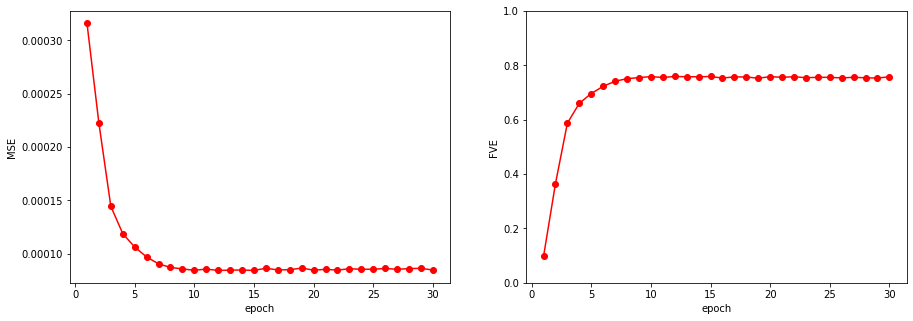

In [5]:
# perform training
loss_train, fve_train = train(ae, dataset)
print("Training complete\n")

# save network
if not os.path.exists('./Net'):
    os.mkdir('./Net')
# saving trained model
save_path = "./Net/ae.pyt"
torch.save(ae.state_dict(), save_path)
save_path = "./Net/encoder.pyt"
torch.save(encoder.state_dict(), save_path)
save_path = "./Net/decoder.pyt"
torch.save(decoder.state_dict(), save_path)

# plot error and fve
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(np.arange(len(loss_train)) + 1, loss_train, 'r-o')
axs[1].plot(np.arange(len(fve_train)) + 1, fve_train, 'r-o')
axs[1].set_ylim(0,1)
axs[0].set_xlabel('epoch')
axs[1].set_xlabel('epoch')
axs[0].set_ylabel('MSE')
axs[1].set_ylabel('FVE')
plt.show()

# Reduce dimensionality

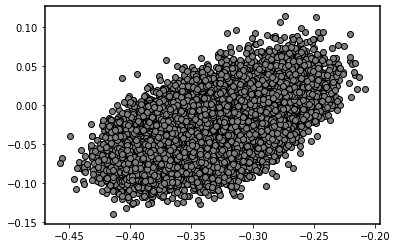

In [6]:
# load encoder
encoder = Encoder(d, 5*d, c)
encoder.load_state_dict(torch.load('./Net/encoder.pyt'))

# project data onto low-dimensional space
proj = encoder(get_var_from_np(dataset))
proj = proj.detach().numpy()

# plot projection
x = proj[:,0]
y = proj[:,1]
fig = plt.figure()
ax = fig.add_subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
plt.scatter(x, y, c= 'grey', edgecolors= 'black')
# plt.xticks([])
# plt.yticks([])
plt.show()


# Clustering via GMMs

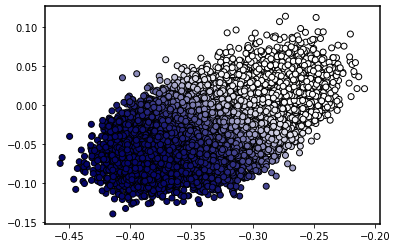

In [7]:
# set number of Gaussian in the mixture and parameters for fitting
n_components = 2
gmm = mixture.GaussianMixture(n_components=n_components,covariance_type='full', \
max_iter=10000, tol=0.001, n_init=10)
# fit data
gmm.fit(proj)
# compute bic
bic = gmm.bic(proj)
# get labels (hard clustering)
Y = gmm.predict(proj)
# get probabilities (soft clustering)
P = gmm.predict_proba(proj)

# plot clustering results
colors = []
for i in range(len(P)):
    R = 1.0-P[i][0]
    G = 1.0-P[i][0]
    B = 1.0-0.6*P[i][0]
    colors.append([R,G,B])
colors = np.array(colors)

fig = plt.figure()
ax = fig.add_subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
plt.scatter(x, y, c=colors, edgecolors= 'black')
# plt.xticks([])
# plt.yticks([])
plt.show()